# Turbidity Current in Axisymmetric Configuration

![image info](Axisymmetric_flow.jpg)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import xcompact3d_toolbox as x3d

c:\users\felip\documents\github\x3d-hackathon_june_21\xcompact3d_toolbox\xcompact3d_toolbox\io.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Parameters

* Numerical precision

Use `np.float64` if Xcompact3d was compiled with the flag `-DDOUBLE_PREC`, use `np.float32` otherwise.

In [2]:
x3d.param["mytype"] = np.float32

* Xcompact3d's parameters

For more information about them, checkout the [API reference](https://xcompact3d-toolbox.readthedocs.io/en/latest/Docstrings.html#xcompact3d_toolbox.parameters.Parameters).

In [3]:
prm = x3d.Parameters(
    filename="input.i3d",
    # BasicParam
    itype=12,
    nx=501,
    ny=73,
    nz=501,
    xlx=20.0,
    yly=2.0,
    zlz=20.0,
    nclx1=1,
    nclxn=1,
    ncly1=2,
    nclyn=1,
    nclz1=1,
    nclzn=1,
    re=3500.0,
    init_noise=0.0125,
    dt=5e-4,
    ifirst=1,
    ilast=80000,
    numscalar=1,
    # ScalarParam
    nclxS1=1,
    nclxSn=1,
    nclyS1=1,
    nclySn=1,
    nclzS1=1,
    nclzSn=1,
    sc=[1.0],
    ri=[0.5],
    uset=[0.0],
    cp=[1.0],
)

## Setup

Everything needed is in one Dataset (see [API reference](https://xcompact3d-toolbox.readthedocs.io/en/latest/Docstrings.html#xcompact3d_toolbox.sandbox.init_dataset)):

In [4]:
ds = x3d.init_dataset(prm)

Let's see it, data and attributes are attached, try to interact with the icons:

In [5]:
ds

<xarray.Dataset>
Dimensions:  (n: 1, x: 501, y: 73, z: 501)
Coordinates:
  * x        (x) float32 0.0 0.04 0.08 0.12 0.16 ... 19.88 19.92 19.96 20.0
  * y        (y) float32 0.0 0.02778 0.05556 0.08333 ... 1.917 1.944 1.972 2.0
  * z        (z) float32 0.0 0.04 0.08 0.12 0.16 ... 19.88 19.92 19.96 20.0
  * n        (n) int32 1
Data variables:
    ux       (x, y, z) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    uy       (x, y, z) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    uz       (x, y, z) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    phi      (n, x, y, z) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

### Initial Condition

A random noise will be applied to the initial velocity field, we start creating a modulation function `mod`, to apply it just near the fresh/turbidity interface:

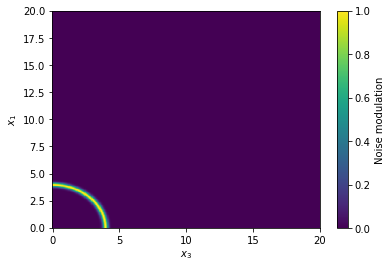

In [6]:
# Position of the initial interface in the polar coordinate
r0 = 4.0

# Random noise with fixed seed,
# important for reproducibility, development and debugging
if prm.iin == 2:
    np.random.seed(seed=67)

radius = np.sqrt(ds.x ** 2 + ds.z ** 2.0)

mod = np.exp(-25.0 * (radius - r0) ** 2.0)

# This attribute will be shown at the colorbar
mod.attrs["long_name"] = "Noise modulation"

mod.plot();

Now we reset velocity fields `ds[key] *= 0.0`, just to guarantee consistency in the case of multiple executions of this cell. Notice that `ds[key] = 0.0` may overwrite all the metadata contained in the array, so it should be avoided.

We then add a random number array with the right shape and multiply by the noise amplitude at the initial condition `init_noise` and multiply again by our modulation function `mod`, defined previously.

Plotting a `xarray.DataArray` is as simple as `da.plot()` (see its [user guide](http://xarray.pydata.org/en/stable/plotting.html)), I'm adding extra options just to exemplify how easily we can slice the vertical coordinate and produce multiple plots:

Initial Condition for Streamwise Velocity


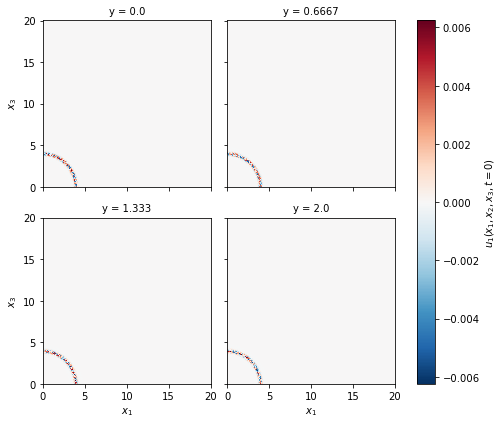

Initial Condition for Vertical Velocity


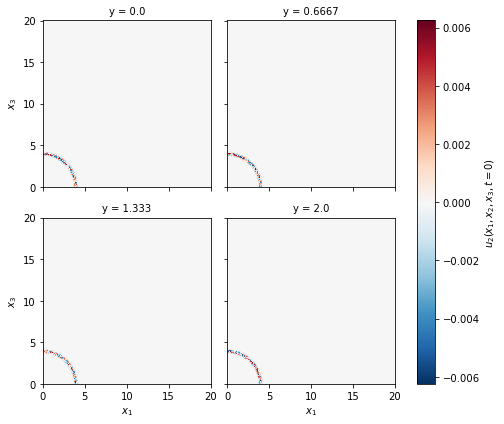

Initial Condition for Spanwise Velocity


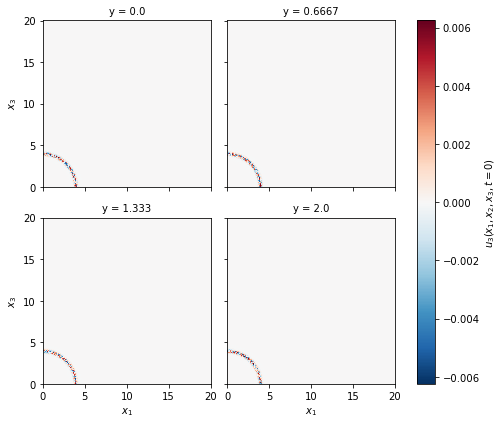

In [7]:
for key in "ux uy uz".split():
    #
    print(ds[key].attrs["name"])
    #
    ds[key] *= 0.0
    #
    ds[key] += prm.init_noise * ((np.random.random(ds[key].shape) - 0.5))
    ds[key] *= mod
    #
    ds[key].sel(y=slice(None, None, ds.y.size // 3)).plot(
        x="x", y="z", col="y", col_wrap=2
    )
    plt.show()

plt.close("all")

A smooth transition at the interface fresh/turbidity fluid is used for the initial concentration(s) field(s), it is defined in the polar coordinates as:

$$
\varphi_n = c_{0,n} \dfrac{1}{2} \left( 1 - \tanh \left( (r - r_0) \sqrt{Sc_n Re} \right) \right).
$$

The code block includes the same procedures, we reset the scalar field `ds['phi'] *= 0.0`, just to guarantee consistency, we compute the equation above, we add it to the array and make a plot:

Initial Condition for Scalar field(s)


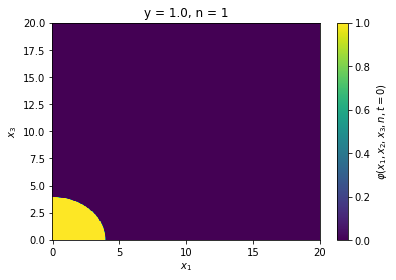

In [8]:
# Concentration

print(ds["phi"].attrs["name"])

ds["phi"] *= 0.0

for n in range(prm.numscalar):
    #
    fun = 0.5 * prm.cp[n] * (1.0 - np.tanh((radius - r0) * (prm.sc[n] * prm.re) ** 0.5))
    #
    ds["phi"][dict(n=n)] += fun
    #
    ds.phi.isel(n=n).sel(y=prm.yly / 2.0).T.plot()
    plt.show()

plt.close("all")

## Writing to disc

is as simple as:

In [9]:
prm.dataset.write(ds)

In [10]:
prm.write()

## Running the Simulation

It was just to show the capabilities of `xcompact3d_toolbox.sandbox`, keep in mind the aspects of numerical stability of our Navier-Stokes solver. **It is up to the user to find the right set of numerical and physical parameters**.

Make sure that the compiling flags and options at `Makefile` are what you expect. Then, compile the main code at the root folder with `make`.

And finally, we are good to go:

```bash
mpirun -n [number of cores] ./xcompact3d |tee log.out
```